# dataset https://www.kaggle.com/datasets/dietzschenostoevsky/pizza-steak-sushi

In [1]:
!nvidia-smi

Fri Feb  2 06:32:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  | 00000000:01:00.0 Off |                  Off |
| 30%   45C    P8              14W / 130W |      2MiB / 20475MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install kaggle

In [3]:
import os



userkaggle       = 'xx'
passkaggle       = 'yyy'

try :
    os.environ['KAGGLE_USERNAME'] = userkaggle
    os.environ['KAGGLE_KEY'] = passkaggle
except :
    print("KAGGLE_USERNAME or KAGGLE_KEY is not set.")
   






In [4]:
import os
from IPython.display import clear_output
import zipfile

if not os.path.exists('pizza-steak-sushi.zip'):
    # Download the dataset
    !kaggle datasets download -d dietzschenostoevsky/pizza-steak-sushi     

if os.path.exists('pizza-steak-sushi.zip') and not os.path.exists('pizza-steak-sushi'):
        # Make directory and unzip
    zip_path = 'pizza-steak-sushi.zip'
    extract_path = 'pizza-steak-sushi'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        
clear_output()



In [5]:
#%% packages
from typing import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils 

#%% Dataset and data loader
path_images = './pizza-steak-sushi/data/pizza_steak_sushi/train'
LATENT_DIMS = 128



transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ResNet input size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
   
])


In [6]:
import glob
import random

subdirectory_path = path_images   # Replace with the actual subdirectory name
image_files = glob.glob(f'{path_images}/*/*.jpg')  # Replace '.jpg' with the file extension of your images

print(f'There are {len(image_files)} images in total in the subdirectory {subdirectory_path}')



There are 700 images in total in the subdirectory ./pizza-steak-sushi/data/pizza_steak_sushi/train


In [7]:
random_images = random.sample(image_files, 700)
print("there are {} images in random_images".format(len(random_images)))



there are 700 images in random_images


# Delete not nessary files

In [8]:
import os

for image_file in image_files:
    if image_file not in random_images:
        os.remove(image_file)

image_files = glob.glob(f'{path_images}/*/*.jpg')  # Replace '.jpg' with the file extension of your images

print(f'There are {len(image_files)} images in total in the subdirectory ')

There are 700 images in total in the subdirectory 


In [9]:
import multiprocessing


dataset = ImageFolder(root=path_images , transform=transform)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True , num_workers=multiprocessing.cpu_count())
# %% model class


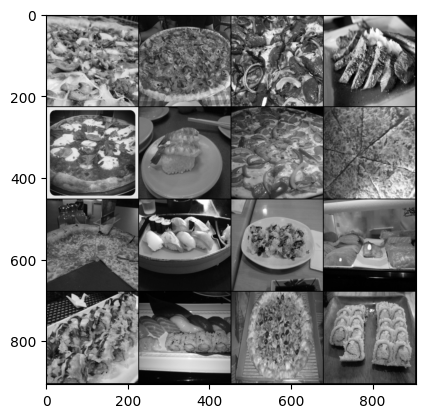

In [10]:
# %%
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    plt.figure() 
    plt.imshow(image_torch) 
 
X_train, y_train = next(iter(dataloader)) 
 
# Make a grid from batch 
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4) 
 
imshow(image_grid) 


In [11]:
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        
        self.gray2rgb = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)
        # Encoder using ResNet18 backbone
        resnet = models.resnet18(pretrained=True)

        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        
        # Extended layer for embedding
        self.embedding_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(512, 512 * 7 * 7),
            nn.ReLU(),
            Unflatten(512, 7, 7),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(3, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Assuming 3-channel output (RGB)
        )

    def forward(self, x):
        x = self.gray2rgb(x)
        x = self.encoder(x)
        embedding = self.embedding_layer(x)
        x = self.decoder(embedding)
        return embedding, x

class Unflatten(nn.Module):
    def __init__(self, C, H, W):
        super(Unflatten, self).__init__()
        self.C = C
        self.H = H
        self.W = W

    def forward(self, x):
        return x.view(-1, self.C, self.H, self.W)


input = torch.randn(5, 1, 224, 224)
model = ResNetAutoencoder()

embedding, x = model(input)
print(embedding.shape,x.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([5, 512]) torch.Size([5, 1, 224, 224])


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Epoch: 50 	Loss: 0.049380319037785135 	Time per epoch: 88.17281 seconds 	CPU Usage: 7.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.49 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 56.26 GB
---------------------------------------------------------------------------------------------
Epoch: 100 	Loss: 0.03552831461032232 	Time per epoch: 87.96513 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.49 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 56.27 GB
---------------------------------------------------------------------------------------------
Epoch: 150 	Loss: 0.02729295815030734 	Time per epoch: 88.14992 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.49 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 56.25 GB
---------------------------------------------------------------------------------------------
Epoch: 200 	Loss: 0.022902403414870303 	Time per epoch: 86.77907 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.49 GB 	GPU Memor

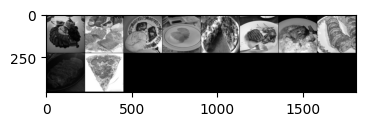

reconstructed


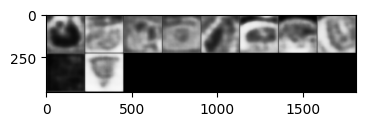

Epoch: 250 	Loss: 0.019815815224622686 	Time per epoch: 87.06797 seconds 	CPU Usage: 11.5% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.76 GB
---------------------------------------------------------------------------------------------
Epoch: 300 	Loss: 0.017958665538268786 	Time per epoch: 87.57503 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.78 GB
---------------------------------------------------------------------------------------------
Epoch: 350 	Loss: 0.016699299255075555 	Time per epoch: 87.57390 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.75 GB
---------------------------------------------------------------------------------------------
Epoch: 400 	Loss: 0.015578500965299705 	Time per epoch: 86.23553 seconds 	CPU Usage: 11.4% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU M

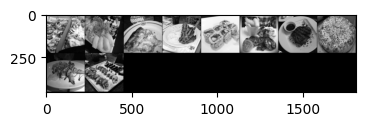

reconstructed


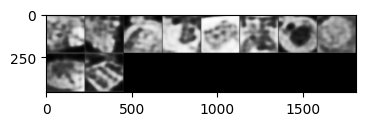

Epoch: 450 	Loss: 0.014622990662852922 	Time per epoch: 87.92360 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.76 GB
---------------------------------------------------------------------------------------------
Epoch: 500 	Loss: 0.013824478102227053 	Time per epoch: 87.70346 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.76 GB
---------------------------------------------------------------------------------------------
Epoch: 550 	Loss: 0.013278872473165393 	Time per epoch: 87.26552 seconds 	CPU Usage: 11.5% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.76 GB
---------------------------------------------------------------------------------------------
Epoch: 600 	Loss: 0.01265521910196791 	Time per epoch: 86.62431 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Me

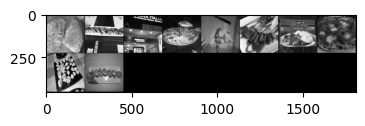

reconstructed


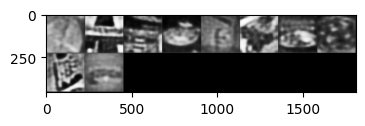

Epoch: 650 	Loss: 0.011967509558113912 	Time per epoch: 87.55593 seconds 	CPU Usage: 11.5% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.81 GB
---------------------------------------------------------------------------------------------
Epoch: 700 	Loss: 0.011416403072265288 	Time per epoch: 87.39536 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.83 GB
---------------------------------------------------------------------------------------------
Epoch: 750 	Loss: 0.01104878494516015 	Time per epoch: 87.05006 seconds 	CPU Usage: 11.5% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.83 GB
---------------------------------------------------------------------------------------------
Epoch: 800 	Loss: 0.010348378253790239 	Time per epoch: 86.79988 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Me

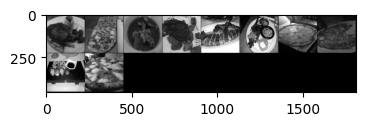

reconstructed


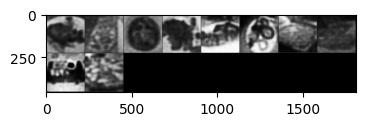

Epoch: 850 	Loss: 0.010031100750590364 	Time per epoch: 88.95658 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.82 GB
---------------------------------------------------------------------------------------------
Epoch: 900 	Loss: 0.009727198087299863 	Time per epoch: 86.89261 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 32.82 GB
---------------------------------------------------------------------------------------------
Epoch: 950 	Loss: 0.009396196304199597 	Time per epoch: 85.91699 seconds 	CPU Usage: 11.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 33.19 GB
---------------------------------------------------------------------------------------------
Epoch: 1000 	Loss: 0.008982864441350102 	Time per epoch: 87.48660 seconds 	CPU Usage: 11.8% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU 

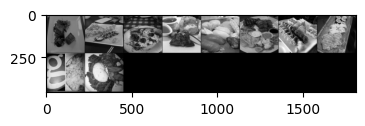

reconstructed


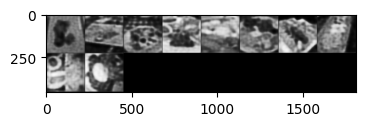

Epoch: 1050 	Loss: 0.008757619749909887 	Time per epoch: 87.39789 seconds 	CPU Usage: 12.7% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 37.12 GB
---------------------------------------------------------------------------------------------
Epoch: 1100 	Loss: 0.008604726889946809 	Time per epoch: 85.54839 seconds 	CPU Usage: 13.5% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 43.19 GB
---------------------------------------------------------------------------------------------
Epoch: 1150 	Loss: 0.008303889073431492 	Time per epoch: 86.12770 seconds 	CPU Usage: 13.6% 	GPU Usage: 100.0%
GPU Memory Usage: 0.50 GB 	GPU Memory Cached: 1.70 GB 	CPU Memory Usage: 49.55 GB
---------------------------------------------------------------------------------------------


In [13]:
import time
import multiprocessing
import psutil
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.cpu().numpy().transpose((1, 2, 0)) 
    plt.figure(figsize=(4, 4)) 
    plt.imshow(image_torch) 
    plt.show()

NUM_EPOCHS = 1200



dataset    = ImageFolder(root=path_images , transform=transform)
dataloader = DataLoader(dataset, batch_size=30, shuffle=True , num_workers=6)
model      = ResNetAutoencoder()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.to(device)
start_time = time.time()  # Start time of the epoch
for epoch in range(NUM_EPOCHS):
  
    losses_epoch = []
    
    for batch_idx, (data, target) in enumerate(dataloader):
        model.train()
        data = data.to(device)
        embedding, output = model(data)

        loss = F.mse_loss(output, data)
        losses_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0 and epoch != 0:  
        end_time = time.time()  # End time of the epoch
        epoch_time = end_time - start_time  # Time taken for the epoch
        gpu_memory_usage = torch.cuda.memory_allocated() / 1024 ** 3  # GPU memory usage in GB
        gpu_memory_cached = torch.cuda.memory_reserved() / 1024 ** 3  # GPU memory cached in GB
        cpu_memory_usage = psutil.virtual_memory().used / 1024 ** 3  # CPU memory usage in GB
        cpu_usage = psutil.cpu_percent()
        gpu_usage = torch.cuda.device_count() / torch.cuda.device_count() * 100
        print(f"Epoch: {epoch} \tLoss: {np.mean(losses_epoch)} \tTime per epoch: {epoch_time:.5f} seconds \tCPU Usage: {cpu_usage}% \tGPU Usage: {gpu_usage}%")
        print(f"GPU Memory Usage: {gpu_memory_usage:.2f} GB \tGPU Memory Cached: {gpu_memory_cached:.2f} GB \tCPU Memory Usage: {cpu_memory_usage:.2f} GB")
        print("---------------------------------------------------------------------------------------------")
        start_time = time.time()  # Start time of the epoch
        
    if epoch % 200 == 0 and epoch != 0:    
        model.eval()    
        images = data
        # %% latent space
        print('latent space')
        embedding, output = model(images)
        print('original')
        imshow(torchvision.utils.make_grid(images))
        print('reconstructed')
        imshow(torchvision.utils.make_grid(output.cpu()))   



original


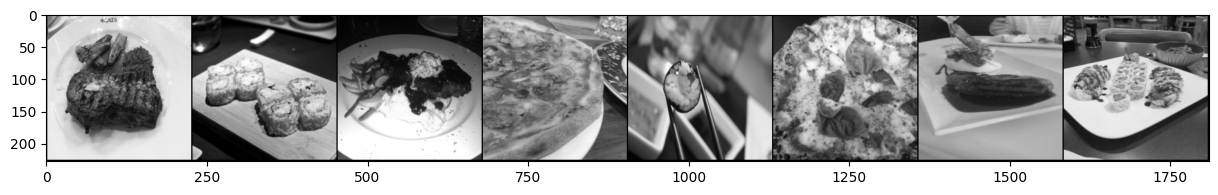

reconstructed


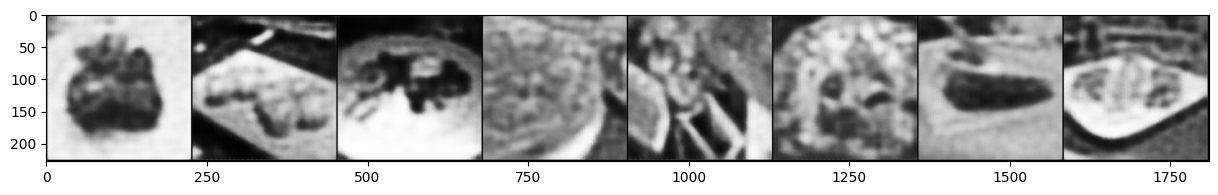

original


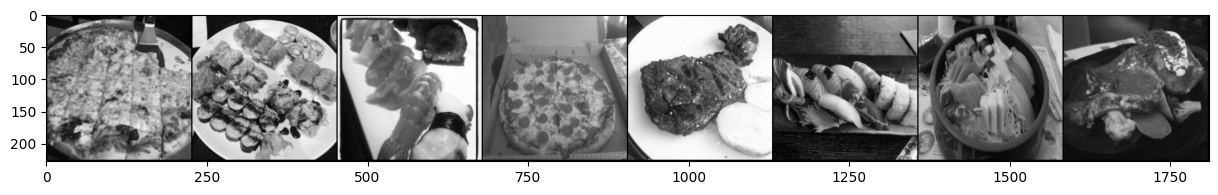

reconstructed


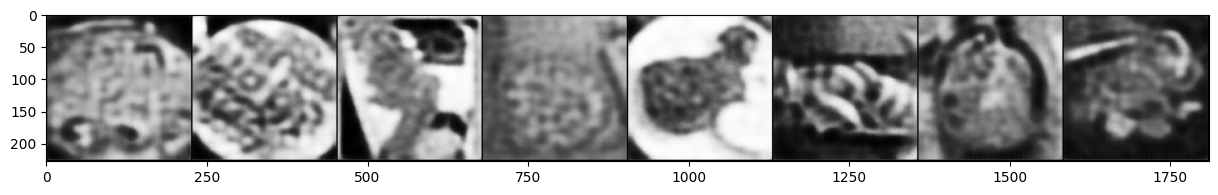

original


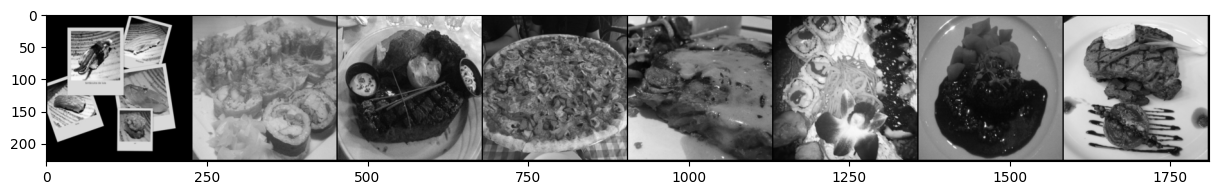

reconstructed


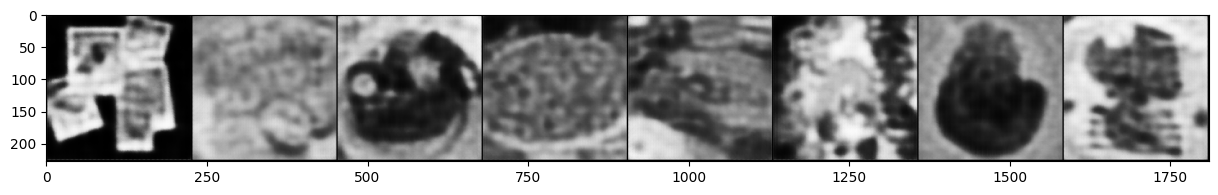

In [24]:
model.eval()    
dataset    = ImageFolder(root=path_images , transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True , num_workers=2)

def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.cpu().numpy().transpose((1, 2, 0)) 
    plt.figure(figsize=(15, 10)) 
    plt.imshow(image_torch) 
    plt.show()


for i in range(3):
    images, labels = next(iter(dataloader))
    print('original')
    imshow(torchvision.utils.make_grid(images))

    images = images.to(device)
    embedding, output = model(images)

    print('reconstructed')
    imshow(torchvision.utils.make_grid(output.cpu()))
 



In [25]:
dataset    = ImageFolder(root=path_images , transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True , num_workers=2)

embedding_vectors = []
model.eval()

for images, labels in dataloader:
    images = images.to(device)
    with torch.no_grad():
        embedding, _ = model(images)
    embedding_vectors.append(embedding.cpu().numpy())

embedding_vectors = np.concatenate(embedding_vectors)


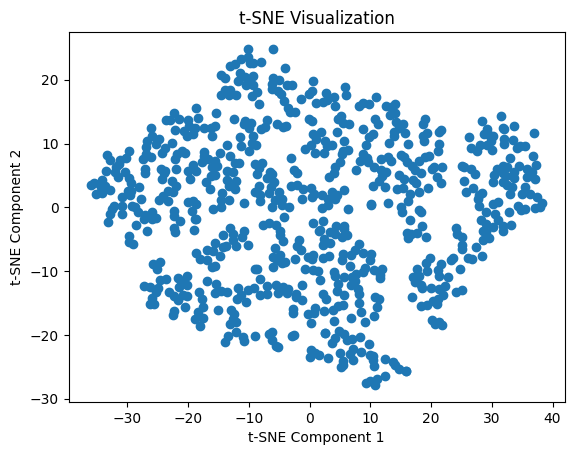

In [30]:
from sklearn.manifold import TSNE

# Apply t-SNE on the PCA embedding
tsne = TSNE(n_components=2)
embedding_tsne = tsne.fit_transform(embedding_pca)

# Plot the results
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()
